In [3]:
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
import gc
import numpy as np
from scipy.stats import entropy
from gensim.models import Word2Vec
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [4]:
def reduce_mem(df):
    starttime = time.time()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.isnull(c_min) or pd.isnull(c_max):
                continue
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('-- Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction),time spend:{:2.2f} min'.format(end_mem,
                                                                                                           100*(start_mem-end_mem)/start_mem,
                                                                                                           (time.time()-starttime)/60))
    return df

In [5]:
# train_df = pd.read_csv('../../data/train_data.csv',sep='|')
# train_df.to_pickle('../../data/train_data.pkl')
# test_df = pd.read_csv('../../data/test_data_A.csv',sep='|')
# test_df.to_pickle('../../data/test_data_A.pkl')

train_df = pd.read_pickle('../../data/train_data.pkl')
test_df = pd.read_pickle('../../data/test_data_A.pkl')
print(train_df.shape)
train_df = train_df.drop_duplicates()
print(train_df.shape)

(60000000, 36)
(52909820, 36)


In [6]:
train_df = reduce_mem(train_df)
test_df = reduce_mem(test_df)

-- Mem. usage decreased to 3027.52 Mb (79.7% reduction),time spend:0.46 min
-- Mem. usage decreased to 104.90 Mb (80.9% reduction),time spend:0.01 min


In [25]:
print(len(train_df), len(test_df))

train_label_0 = train_df[ train_df['label'] == 0 ]
train_label_1 = train_df[ train_df['label'] == 1 ]
print(train_label_0.shape, train_label_1.shape)

52909820 2000000
(50937400, 36) (1972420, 36)


In [26]:
# train_df.pt_d.value_counts() #pt_d:1-7
train_df.head()

,label,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,...,list_time,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d
0,0,1919789,7320,6624,2,244,75,4,19,13,...,35,3,18,-1,-1,6,4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^2...,11,45,7
1,0,3712854,3211,4703,2,168,72,4,19,82,...,34,2,-1,-1,-1,6,2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^...,12,45,6
2,0,1097359,6133,7773,8,282,18,4,13,24,...,29,3,20,-1,-1,8,3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20...,11,24,5
3,0,1762458,6505,5605,2,230,16,4,12,38,...,29,3,-1,-1,-1,6,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,45,5
4,0,2977228,2820,8320,2,230,16,4,13,38,...,41,2,20,1,-1,5,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,12,45,1


In [27]:
MY_SEED = 1997

In [28]:

train_label_0 = train_label_0.sample(n = 1972420*2 , random_state = MY_SEED).reset_index(drop=True)
train_label_1 = train_label_1.sample(n = 1972420 , random_state = MY_SEED).reset_index(drop=True)
print(train_label_0.shape, train_label_1.shape)

train = pd.concat([train_label_0,train_label_1]).reset_index(drop=True)
train = train.sample(frac = 1, random_state = MY_SEED+1 ).reset_index(drop=True)
print(train.shape)
print(train['label'].value_counts())

train['my_index'] = list(range(train.shape[0]))  #确保顺序
test_df['my_index'] = list(range(test_df.shape[0]))

df = pd.concat([train,test_df],axis=0).reset_index(drop=True)

del train_label_0, train_label_1
# del train_df, test_df
del train
gc.collect()

df.head(10)

(3944840, 36) (1972420, 36)
(5917260, 36)
0    3944840
1    1972420
Name: label, dtype: int64


/home/amax/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,adv_id,adv_prim_id,age,app_first_class,app_score,app_second_class,career,city,city_rank,communication_avgonline_30d,...,net_type,pt_d,residence,slot_id,spread_app_id,tags,task_id,uid,up_life_duration,up_membership_grade
0,4581,230,5,3,0,21,2,221,3,12,...,5,1,15,15,38,37,7568,1557143,20,1
1,4511,144,3,3,0,15,10,408,5,12,...,2,6,17,15,74,29,5473,3157674,20,-1
2,7617,227,4,3,0,26,9,186,5,9,...,5,1,25,21,22,32,4217,3878806,20,-1
3,1531,154,5,3,0,15,7,277,3,12,...,2,2,32,12,74,29,4322,2605501,18,-1
4,6737,215,6,3,0,17,9,397,5,12,...,2,4,23,14,58,41,7894,3055239,-1,-1
5,8582,244,4,3,0,21,5,403,5,13,...,2,7,28,22,13,37,3502,3293472,18,-1
6,8347,248,7,4,0,22,9,403,5,10,...,5,2,28,12,69,25,5555,1659181,14,-1
7,7289,279,7,3,0,12,9,196,3,12,...,2,1,24,13,37,27,4770,2992819,18,-1
8,4372,144,4,3,0,15,9,421,5,12,...,2,2,14,21,74,29,4487,1629815,18,-1
9,1427,284,5,3,0,17,9,217,2,11,...,5,6,34,13,23,41,3339,3979326,20,-1


In [29]:
###############communication_onlinerate feature##############
df_co_len = df.communication_onlinerate.copy()
df_co_len = df_co_len.apply(lambda x:len(str(x).strip().split('^')))
df['co_len'] = df_co_len.values

df['min_co'] = df.communication_onlinerate.apply(lambda x:int(x.split('^')[0]))
df['max_co'] = df.communication_onlinerate.apply(lambda x:int(x.split('^')[-1]))

del df_co_len
gc.collect()

34

In [30]:
##########################cate feature#######################
cate_cols = ['slot_id','adv_id','adv_prim_id','creat_type_cd','inter_type_cd','age','city','uid','dev_id','task_id']

for f in tqdm(cate_cols):
    map_dict = dict(zip(df[f].unique(), range(df[f].nunique())))
    df[f] = df[f].map(map_dict)
    df[f + '_count'] = df[f].map(df[f].value_counts())
df = reduce_mem(df)

100%|██████████| 10/10 [00:05<00:00,  1.43it/s]


-- Mem. usage decreased to 800.35 Mb (56.2% reduction),time spend:0.02 min


In [31]:
df.head(10)

,adv_id,adv_prim_id,age,app_first_class,app_score,app_second_class,career,city,city_rank,communication_avgonline_30d,...,slot_id_count,adv_id_count,adv_prim_id_count,creat_type_cd_count,inter_type_cd_count,age_count,city_count,uid_count,dev_id_count,task_id_count
0,0,0,0,3,0,21,2,0,3,12,...,455603,60393,228107,5579698,6077823,2065845,155286,12,1258265,60393
1,1,1,1,3,0,15,10,1,5,12,...,455603,41433,344969,5579698,6077823,246291,288321,8,1258265,41433
2,2,2,2,3,0,26,9,2,5,9,...,875763,194,185166,72513,6077823,1348191,58694,4,185166,194
3,3,3,0,3,0,15,7,3,3,12,...,614756,110,108439,5579698,6077823,2065845,11074,8,1258265,110
4,4,4,3,3,0,17,9,4,5,12,...,254139,29229,362104,322188,6077823,2168589,107332,2,557287,29229
5,5,5,2,3,0,21,5,5,5,13,...,770191,35523,102787,5579698,6077823,1348191,346867,4,330136,35523
6,6,6,4,4,0,22,9,5,5,10,...,614756,1845,53023,416917,588236,1794540,346867,13,1111419,5659
7,7,7,4,3,0,12,9,6,3,12,...,2223262,379,5671,5579698,6077823,1794540,4497,12,5478,379
8,8,1,2,3,0,15,9,7,5,12,...,875763,9775,344969,896876,6077823,1348191,133067,2,1258265,9775
9,9,8,0,3,0,17,9,8,2,11,...,2223262,2312,31951,5579698,1216476,2065845,61961,22,315966,2312


In [32]:
##########################groupby feature#######################
def group_fea(df,key,target):
    tmp = df.groupby(key, as_index=False)[target].agg({
        key+target + '_nunique': 'nunique',
    }).reset_index()
    del tmp['index']
    print("**************************{}**************************".format(target))
    return tmp

feature_key = ['uid']
feature_target = ['slot_id','net_type','task_id','adv_id','adv_prim_id','creat_type_cd','dev_id','tags','spread_app_id','indu_name']

for key in tqdm(feature_key):
    for target in feature_target:
        tmp = group_fea(df,key,target)
        df = df.merge(tmp,on=key,how='left')
        
tmp = group_fea(df,'spread_app_id','task_id')
df = df.merge(tmp,on='spread_app_id',how='left')
tmp = group_fea(df,'spread_app_id','adv_id')
df = df.merge(tmp,on='spread_app_id',how='left')
tmp = group_fea(df,'net_type','slot_id')
df = df.merge(tmp,on='net_type',how='left')
del tmp
gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

**************************slot_id**************************
**************************net_type**************************
**************************task_id**************************
**************************adv_id**************************
**************************adv_prim_id**************************
**************************creat_type_cd**************************
**************************dev_id**************************
**************************tags**************************
**************************spread_app_id**************************
**************************indu_name**************************


100%|██████████| 1/1 [01:03<00:00, 63.06s/it]


**************************task_id**************************
**************************adv_id**************************
**************************slot_id**************************


371

In [33]:
df.shape

(7917260, 63)

In [34]:
def emb(df, f1, f2):
    emb_size = 8 # 8
    t = time.time()
    print('====================================== {} {} ======================================'.format(f1, f2))
    tmp = df.groupby(f1, as_index=False)[f2].agg({'{}_{}_list'.format(f1, f2): list})
    sentences = tmp['{}_{}_list'.format(f1, f2)].values.tolist()
    del tmp['{}_{}_list'.format(f1, f2)]
    for i in range(len(sentences)):
        sentences[i] = [str(x) for x in sentences[i]]
    model = Word2Vec(sentences, size=emb_size, window=5, min_count=5, sg=0, hs=1, seed=MY_SEED+2 )
    emb_matrix = []
    for seq in sentences:
        vec = []
        for w in seq:
            if w in model:
                vec.append(model[w])
        if len(vec) > 0:
            emb_matrix.append(np.mean(vec, axis=0))
        else:
            emb_matrix.append([0] * emb_size)
    for i in range(emb_size):
        #print(i)
        tmp['{}_{}_emb_{}'.format(f1, f2, i)] = np.array(emb_matrix)[:, i]
    del model, emb_matrix, sentences
    tmp = reduce_mem(tmp)
    print('runtime:', time.time() - t)
    return tmp

In [35]:
emb_cols = [
    ['uid', 'task_id'],
    ['uid', 'adv_id'],
    ['uid', 'slot_id'],
    ['uid', 'tags'],
#     ['uid','indu_name'] max_import 0.38
    ['uid', 'dev_id'],
    ['uid', 'adv_prim_id'],
    ['uid', 'spread_app_id'],
#     ['age', 'task_id'], max_import 0.28
#     ['age', 'adv_id'], max_import 0.30
    # ...
]
for f1, f2 in tqdm(emb_cols):
    df = df.merge(emb(df, f1, f2), on=f1, how='left')
    gc.collect()

  0%|          | 0/7 [00:00<?, ?it/s]

====================================== uid task_id ======================================


/home/amax/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  from ipykernel import kernelapp as app
/home/amax/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


-- Mem. usage decreased to 59.35 Mb (65.0% reduction),time spend:0.00 min
runtime: 207.57189869880676


 14%|█▍        | 1/7 [03:32<21:12, 212.04s/it]

====================================== uid adv_id ======================================
-- Mem. usage decreased to 59.35 Mb (65.0% reduction),time spend:0.00 min
runtime: 206.68548130989075


 29%|██▊       | 2/7 [07:03<17:39, 211.80s/it]

====================================== uid slot_id ======================================
-- Mem. usage decreased to 59.35 Mb (41.7% reduction),time spend:0.00 min
runtime: 194.2213432788849


 43%|████▎     | 3/7 [10:22<13:51, 207.96s/it]

====================================== uid tags ======================================
-- Mem. usage decreased to 59.35 Mb (41.7% reduction),time spend:0.00 min
runtime: 195.20939898490906


 57%|█████▋    | 4/7 [13:42<10:16, 205.61s/it]

====================================== uid dev_id ======================================
-- Mem. usage decreased to 59.35 Mb (41.7% reduction),time spend:0.00 min
runtime: 197.89494967460632


 71%|███████▏  | 5/7 [17:05<06:49, 204.84s/it]

====================================== uid adv_prim_id ======================================
-- Mem. usage decreased to 59.35 Mb (41.7% reduction),time spend:0.00 min
runtime: 194.35126733779907


 86%|████████▌ | 6/7 [20:25<03:23, 203.31s/it]

====================================== uid spread_app_id ======================================
-- Mem. usage decreased to 59.35 Mb (41.7% reduction),time spend:0.00 min
runtime: 194.8697304725647


100%|██████████| 7/7 [23:45<00:00, 202.44s/it]


In [36]:
df.shape

(7917260, 119)

In [37]:
df = reduce_mem(df)
df.columns

-- Mem. usage decreased to 1759.26 Mb (27.6% reduction),time spend:0.20 min


Index(['adv_id', 'adv_prim_id', 'age', 'app_first_class', 'app_score',
       'app_second_class', 'career', 'city', 'city_rank',
       'communication_avgonline_30d',
       ...
       'uid_adv_prim_id_emb_6', 'uid_adv_prim_id_emb_7',
       'uid_spread_app_id_emb_0', 'uid_spread_app_id_emb_1',
       'uid_spread_app_id_emb_2', 'uid_spread_app_id_emb_3',
       'uid_spread_app_id_emb_4', 'uid_spread_app_id_emb_5',
       'uid_spread_app_id_emb_6', 'uid_spread_app_id_emb_7'],
      dtype='object', length=119)

In [38]:
feature = pd.DataFrame()

to_group = [
        ['task_id'],['adv_id'],['uid'],['uid_count'],['adv_prim_id'],['city']]    # ['slot_id','age','residence'] is bad

to_inter = [
#     'age',
#     'his_app_size',
#     'city_rank',
#     'his_on_shelf_time',
#     'emui_dev',
#     'device_price',
#     'up_life_duration',
    'list_time',
    'communication_avgonline_30d',
]

to_calc = [
    'mean',
    'std',
    'skew',
]

for i in tqdm(to_group):
    for j in to_inter:
        for k in to_calc:
            feature["STAT_{}_{}_{}".format("_".join(i),j,k)] = df[i + [j]].groupby(i)[j].transform(k)
            
print(feature.shape)
feature.reset_index(drop=True, inplace=True)
df[feature.columns] = feature
df.shape

100%|██████████| 6/6 [08:27<00:00, 52.85s/it] 


(7917260, 36)


(7917260, 155)

In [39]:
def get_history_features(df,col,windows):
        
    tmp = df[[col,'pt_d','label']].groupby([col,'pt_d'], as_index=False)['label'].agg({f'{col}_prev_{windows}_day_click_count': 'sum'})
    tmp['pt_d'] += windows
    df = df.merge(tmp, on=[col,'pt_d'], how='left')
    df[f'{col}_prev_{windows}_day_click_count'] = df[f'{col}_prev_{windows}_day_click_count'].fillna(0)
#     df.loc[df['pt_d'] == windows, f'{col}_prev_{windows}_day_click_count'] = None

    
    tmp = df[[col ,'pt_d', 'label']].groupby([col,'pt_d'], as_index=False)['label'].agg({f'{col}_prev_{windows}_day_count': 'count'})
    tmp['pt_d'] += windows
    df = df.merge(tmp, on= [col,'pt_d'], how='left')
    df[f'{col}_prev_{windows}_day_count'] = df[f'{col}_prev_{windows}_day_count'].fillna(0)
#     df.loc[df['pt_d'] == windows, f'{col}_prev_{windows}_day_count'] = None
        
        
    df[f'{col}_prev_{windows}_day_ctr'] = df[f'{col}_prev_{windows}_day_click_count'] / (
                df[f'{col}_prev_{windows}_day_count'] + df[f'{col}_prev_{windows}_day_count'].mean())
    del df[f'{col}_prev_{windows}_day_click_count']
    del df[f'{col}_prev_{windows}_day_count']
    del tmp
    return df

In [40]:
%%time 
#   对数据历史信息进行挖掘 window=1,2,3
for f in [
    ['uid'],
    ['task_id'],
    ['adv_id'],
    ['adv_prim_id'],
    ['uid_count'],
    # ...
]:
    df = get_history_features(df,f[0],1)
    df = get_history_features(df,f[0],2)
    df = get_history_features(df,f[0],3)

df = reduce_mem(df)
df.columns

-- Mem. usage decreased to 2665.32 Mb (44.9% reduction),time spend:0.30 min
CPU times: user 16min 54s, sys: 26.1 s, total: 17min 20s
Wall time: 4min 19s


Index(['adv_id', 'adv_prim_id', 'age', 'app_first_class', 'app_score',
       'app_second_class', 'career', 'city', 'city_rank',
       'communication_avgonline_30d',
       ...
       'task_id_prev_3_day_ctr', 'adv_id_prev_1_day_ctr',
       'adv_id_prev_2_day_ctr', 'adv_id_prev_3_day_ctr',
       'adv_prim_id_prev_1_day_ctr', 'adv_prim_id_prev_2_day_ctr',
       'adv_prim_id_prev_3_day_ctr', 'uid_count_prev_1_day_ctr',
       'uid_count_prev_2_day_ctr', 'uid_count_prev_3_day_ctr'],
      dtype='object', length=170)

In [41]:
%%time
#   对uid历史信息进行挖掘 window=4,5,6
for f in [
    ['uid'],
]:
    df = get_history_features(df,f[0],4)
    df = get_history_features(df,f[0],5)
    df = get_history_features(df,f[0],6)

df = reduce_mem(df)
df.columns

-- Mem. usage decreased to 2710.63 Mb (4.8% reduction),time spend:0.31 min
CPU times: user 6min 45s, sys: 12.3 s, total: 6min 57s
Wall time: 1min 28s


Index(['adv_id', 'adv_prim_id', 'age', 'app_first_class', 'app_score',
       'app_second_class', 'career', 'city', 'city_rank',
       'communication_avgonline_30d',
       ...
       'adv_id_prev_3_day_ctr', 'adv_prim_id_prev_1_day_ctr',
       'adv_prim_id_prev_2_day_ctr', 'adv_prim_id_prev_3_day_ctr',
       'uid_count_prev_1_day_ctr', 'uid_count_prev_2_day_ctr',
       'uid_count_prev_3_day_ctr', 'uid_prev_4_day_ctr', 'uid_prev_5_day_ctr',
       'uid_prev_6_day_ctr'],
      dtype='object', length=173)

In [42]:
test_df = df[df["pt_d"]==8].copy().reset_index()
train_df = df[df["pt_d"]<8].reset_index()
del df
gc.collect()

125

In [43]:
# %%time
# #统计做了groupby特征的特征
# group_list = []
# for s in train_df.columns:
#      if '_nunique' in s:
#          group_list.append(s)
# print(group_list)

In [44]:
%%time
########################## new target_enc feature#######################
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=MY_SEED+3 ) # 1234 diffenrent
add_list = ['task_id_count', 'adv_id_count', 'uidtask_id_nunique', 'uidadv_id_nunique', 'uidslot_id_nunique', 'spread_app_idtask_id_nunique']
for f in tqdm(add_list + ['uid','task_id','adv_id','uid_count','adv_prim_id','dev_id','age', 'city','device_name','device_size','communication_onlinerate']):
    for method in ['mean', 'std', 'skew']:
        train_df[f + '_te_' + method] = 0
        test_df[f + '_te_' + method] = 0
        for i, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
            trn_x = train_df[[f, 'label']].iloc[trn_idx].reset_index(drop=True)
            val_x = train_df[[f]].iloc[val_idx].reset_index(drop=True)
            enc_df = trn_x.groupby(f, as_index=False)['label'].agg({f + '_te_' + method: method})
            val_x = val_x.merge(enc_df, on=f, how='left')
            test_x = test_df[[f]].merge(enc_df, on=f, how='left')
            val_x[f + '_te_' + method].fillna(val_x[f + '_te_' + method].mean(), inplace=True)
            test_x[f + '_te_' + method].fillna(test_x[f + '_te_' + method].mean(), inplace=True)
            train_df.loc[val_idx, f + '_te_' + method] = val_x[f + '_te_' + method].values
            test_df[f + '_te_' + method] += test_x[f + '_te_' + method].values / skf.n_splits

100%|██████████| 17/17 [23:22<00:00, 31.36s/it] 

CPU times: user 1h 18s, sys: 50.6 s, total: 1h 1min 8s
Wall time: 23min 22s


In [45]:
df = pd.concat([train_df,test_df],axis=0).reset_index(drop=True)
df = reduce_mem(df)
df.to_pickle('feature/all_feature_1bi2_seed'+str(MY_SEED)+'.pkl')
# df = pd.read_pickle('./base++_feature_1bi5.pkl')

-- Mem. usage decreased to 3510.98 Mb (40.0% reduction),time spend:0.45 min


In [46]:
test_df = df[df["pt_d"]==8].copy().reset_index()
del df
train_df = reduce_mem(train_df)
test_df = reduce_mem(test_df)
gc.collect()

-- Mem. usage decreased to 2578.91 Mb (40.4% reduction),time spend:0.33 min
-- Mem. usage decreased to 879.29 Mb (0.9% reduction),time spend:0.11 min


162

In [47]:
#筛选特征
drop_fea = ['pt_d','label','communication_onlinerate','index','Unnamed: 0', 'id']
feature= [x for x in train_df.columns if x not in drop_fea]
print(len(feature))
print(feature)

220
['adv_id', 'adv_prim_id', 'age', 'app_first_class', 'app_score', 'app_second_class', 'career', 'city', 'city_rank', 'communication_avgonline_30d', 'consume_purchase', 'creat_type_cd', 'dev_id', 'device_name', 'device_price', 'device_size', 'emui_dev', 'gender', 'his_app_size', 'his_on_shelf_time', 'indu_name', 'inter_type_cd', 'list_time', 'membership_life_duration', 'net_type', 'residence', 'slot_id', 'spread_app_id', 'tags', 'task_id', 'uid', 'up_life_duration', 'up_membership_grade', 'co_len', 'min_co', 'max_co', 'slot_id_count', 'adv_id_count', 'adv_prim_id_count', 'creat_type_cd_count', 'inter_type_cd_count', 'age_count', 'city_count', 'uid_count', 'dev_id_count', 'task_id_count', 'uidslot_id_nunique', 'uidnet_type_nunique', 'uidtask_id_nunique', 'uidadv_id_nunique', 'uidadv_prim_id_nunique', 'uidcreat_type_cd_nunique', 'uiddev_id_nunique', 'uidtags_nunique', 'uidspread_app_id_nunique', 'uidindu_name_nunique', 'spread_app_idtask_id_nunique', 'spread_app_idadv_id_nunique', 'net

In [48]:
#   五折交叉
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=MY_SEED+5)
oof =  np.zeros(len(train_df)) 
predictions =np.zeros(len(test_df))
y_train = train_df['label']
for i, (trn, val) in enumerate(folds.split(train_df.values,y_train.values)):
    print("Fold:",i+1)
    
    trn_x = train_df.iloc[trn][feature]
    trn_y = y_train.iloc[trn]
    val_x = train_df.iloc[val][feature]
    val_y = y_train.iloc[val]
    
    clf = CatBoostClassifier(iterations=4000, depth=8,learning_rate=0.05, l2_leaf_reg=50, loss_function='Logloss'
                        ,verbose=True,eval_metric='AUC',counter_calc_method='Full',task_type='GPU',devices='0-3',metric_period=50)
    clf.fit(
    trn_x[feature], trn_y.astype('int32'),
    eval_set=[(val_x[feature],val_y.astype('int32'))],
    early_stopping_rounds=50,
    verbose=True,
    use_best_model=True)
    oof[val] = clf.predict_proba(train_df.iloc[val][feature])[:, 1]
    predictions += clf.predict_proba(test_df[feature])[:, 1] / folds.n_splits
    del trn_x
    del trn_y
    del val_x
    del val_y
    gc.collect()

#auc_score =roc_auc_score(y_train, oof)
#print("AUC Score (Valid): %f" % auc_score)

Fold: 1
0:	learn: 0.7951574	test: 0.7953714	best: 0.7953714 (0)	total: 94.8ms	remaining: 6m 19s
50:	learn: 0.8082063	test: 0.8084386	best: 0.8084386 (50)	total: 2.86s	remaining: 3m 41s
100:	learn: 0.8109260	test: 0.8110665	best: 0.8110665 (100)	total: 5.42s	remaining: 3m 29s
150:	learn: 0.8122572	test: 0.8123145	best: 0.8123145 (150)	total: 7.9s	remaining: 3m 21s
200:	learn: 0.8131809	test: 0.8131283	best: 0.8131283 (200)	total: 10.4s	remaining: 3m 17s
250:	learn: 0.8139490	test: 0.8137748	best: 0.8137748 (250)	total: 12.9s	remaining: 3m 12s
300:	learn: 0.8145271	test: 0.8142344	best: 0.8142344 (300)	total: 15.4s	remaining: 3m 8s
350:	learn: 0.8150281	test: 0.8145977	best: 0.8145977 (350)	total: 17.8s	remaining: 3m 4s
400:	learn: 0.8154984	test: 0.8149472	best: 0.8149472 (400)	total: 20.3s	remaining: 3m 1s
450:	learn: 0.8158964	test: 0.8152152	best: 0.8152152 (450)	total: 22.6s	remaining: 2m 58s
500:	learn: 0.8162464	test: 0.8154433	best: 0.8154433 (500)	total: 25s	remaining: 2m 54s
55

350:	learn: 0.8151228	test: 0.8142560	best: 0.8142560 (350)	total: 17.7s	remaining: 3m 4s
400:	learn: 0.8155802	test: 0.8145823	best: 0.8145823 (400)	total: 20.1s	remaining: 3m
450:	learn: 0.8159868	test: 0.8148749	best: 0.8148749 (450)	total: 22.6s	remaining: 2m 57s
500:	learn: 0.8163614	test: 0.8151205	best: 0.8151205 (500)	total: 25s	remaining: 2m 54s
550:	learn: 0.8166836	test: 0.8153245	best: 0.8153245 (550)	total: 27.5s	remaining: 2m 51s
600:	learn: 0.8170263	test: 0.8155239	best: 0.8155239 (600)	total: 29.9s	remaining: 2m 49s
650:	learn: 0.8173201	test: 0.8156943	best: 0.8156943 (650)	total: 32.4s	remaining: 2m 46s
700:	learn: 0.8175901	test: 0.8158443	best: 0.8158443 (700)	total: 34.9s	remaining: 2m 44s
750:	learn: 0.8178367	test: 0.8159719	best: 0.8159719 (750)	total: 37.2s	remaining: 2m 41s
800:	learn: 0.8180839	test: 0.8160970	best: 0.8160970 (800)	total: 39.6s	remaining: 2m 38s
850:	learn: 0.8183217	test: 0.8162194	best: 0.8162194 (850)	total: 42s	remaining: 2m 35s
900:	lea

750:	learn: 0.8180221	test: 0.8156537	best: 0.8156537 (750)	total: 37.4s	remaining: 2m 41s
800:	learn: 0.8182629	test: 0.8157814	best: 0.8157814 (800)	total: 39.8s	remaining: 2m 39s
850:	learn: 0.8184806	test: 0.8158922	best: 0.8158922 (850)	total: 42.2s	remaining: 2m 36s
900:	learn: 0.8187056	test: 0.8159981	best: 0.8159981 (900)	total: 44.6s	remaining: 2m 33s
950:	learn: 0.8189245	test: 0.8160963	best: 0.8160963 (950)	total: 47s	remaining: 2m 30s
1000:	learn: 0.8191339	test: 0.8161852	best: 0.8161852 (1000)	total: 49.4s	remaining: 2m 28s
1050:	learn: 0.8193249	test: 0.8162617	best: 0.8162617 (1050)	total: 51.8s	remaining: 2m 25s
1100:	learn: 0.8195188	test: 0.8163351	best: 0.8163351 (1100)	total: 54.2s	remaining: 2m 22s
1150:	learn: 0.8197300	test: 0.8164184	best: 0.8164184 (1150)	total: 56.6s	remaining: 2m 20s
1200:	learn: 0.8199177	test: 0.8164835	best: 0.8164835 (1200)	total: 59.1s	remaining: 2m 17s
1250:	learn: 0.8200932	test: 0.8165471	best: 0.8165471 (1250)	total: 1m 1s	remaini

1150:	learn: 0.8196529	test: 0.8168342	best: 0.8168342 (1150)	total: 56.6s	remaining: 2m 20s
1200:	learn: 0.8198365	test: 0.8169051	best: 0.8169051 (1200)	total: 59s	remaining: 2m 17s
1250:	learn: 0.8200229	test: 0.8169688	best: 0.8169688 (1250)	total: 1m 1s	remaining: 2m 15s
1300:	learn: 0.8202007	test: 0.8170286	best: 0.8170286 (1300)	total: 1m 3s	remaining: 2m 12s
1350:	learn: 0.8203882	test: 0.8170918	best: 0.8170918 (1350)	total: 1m 6s	remaining: 2m 9s
1400:	learn: 0.8205496	test: 0.8171426	best: 0.8171426 (1400)	total: 1m 8s	remaining: 2m 7s
1450:	learn: 0.8207092	test: 0.8171870	best: 0.8171870 (1450)	total: 1m 11s	remaining: 2m 4s
1500:	learn: 0.8208761	test: 0.8172343	best: 0.8172345 (1499)	total: 1m 13s	remaining: 2m 2s
1550:	learn: 0.8210437	test: 0.8172833	best: 0.8172833 (1550)	total: 1m 15s	remaining: 1m 59s
1600:	learn: 0.8211920	test: 0.8173234	best: 0.8173234 (1600)	total: 1m 18s	remaining: 1m 57s
1650:	learn: 0.8213577	test: 0.8173697	best: 0.8173697 (1650)	total: 1m 

1550:	learn: 0.8210522	test: 0.8171908	best: 0.8171912 (1548)	total: 1m 15s	remaining: 1m 59s
1600:	learn: 0.8212162	test: 0.8172320	best: 0.8172320 (1600)	total: 1m 18s	remaining: 1m 57s
1650:	learn: 0.8213615	test: 0.8172696	best: 0.8172696 (1650)	total: 1m 20s	remaining: 1m 54s
1700:	learn: 0.8215267	test: 0.8173172	best: 0.8173172 (1699)	total: 1m 23s	remaining: 1m 52s
1750:	learn: 0.8216845	test: 0.8173584	best: 0.8173584 (1750)	total: 1m 25s	remaining: 1m 49s
1800:	learn: 0.8218351	test: 0.8173934	best: 0.8173934 (1800)	total: 1m 27s	remaining: 1m 47s
1850:	learn: 0.8219677	test: 0.8174224	best: 0.8174224 (1850)	total: 1m 30s	remaining: 1m 44s
1900:	learn: 0.8221190	test: 0.8174623	best: 0.8174623 (1900)	total: 1m 32s	remaining: 1m 42s
1950:	learn: 0.8222626	test: 0.8174930	best: 0.8174930 (1949)	total: 1m 34s	remaining: 1m 39s
2000:	learn: 0.8224093	test: 0.8175289	best: 0.8175293 (1998)	total: 1m 37s	remaining: 1m 37s
2050:	learn: 0.8225622	test: 0.8175613	best: 0.8175615 (2047

In [49]:
auc_score =roc_auc_score(y_train, oof)
print("AUC Score (Valid): %f" % auc_score)
print('开始储存')
res = pd.DataFrame()
res['id'] = test_df['id'].astype('int32')
res['probability'] = predictions
res.to_csv('result/cat_seed_+'+str(MY_SEED)+'_test_pred_{}.csv'.format(auc_score),index = False)
res.head(5)

AUC Score (Valid): 0.818434
开始储存


,id,probability
0,1,0.138659
1,2,0.753885
2,3,0.060560
3,4,0.090384
4,5,0.702350


In [50]:
oof.shape

(5917260,)

In [51]:
print('开始储存off')
res_oof = pd.DataFrame()
res_oof['probability'] = oof
res_oof.to_csv('result/cat_seed_+'+str(MY_SEED)+'_train_pred__{}.csv'.format(auc_score),index = False)
res_oof.head()

开始储存off


,probability
0,0.089701
1,0.094345
2,0.081762
3,0.133432
4,0.252464


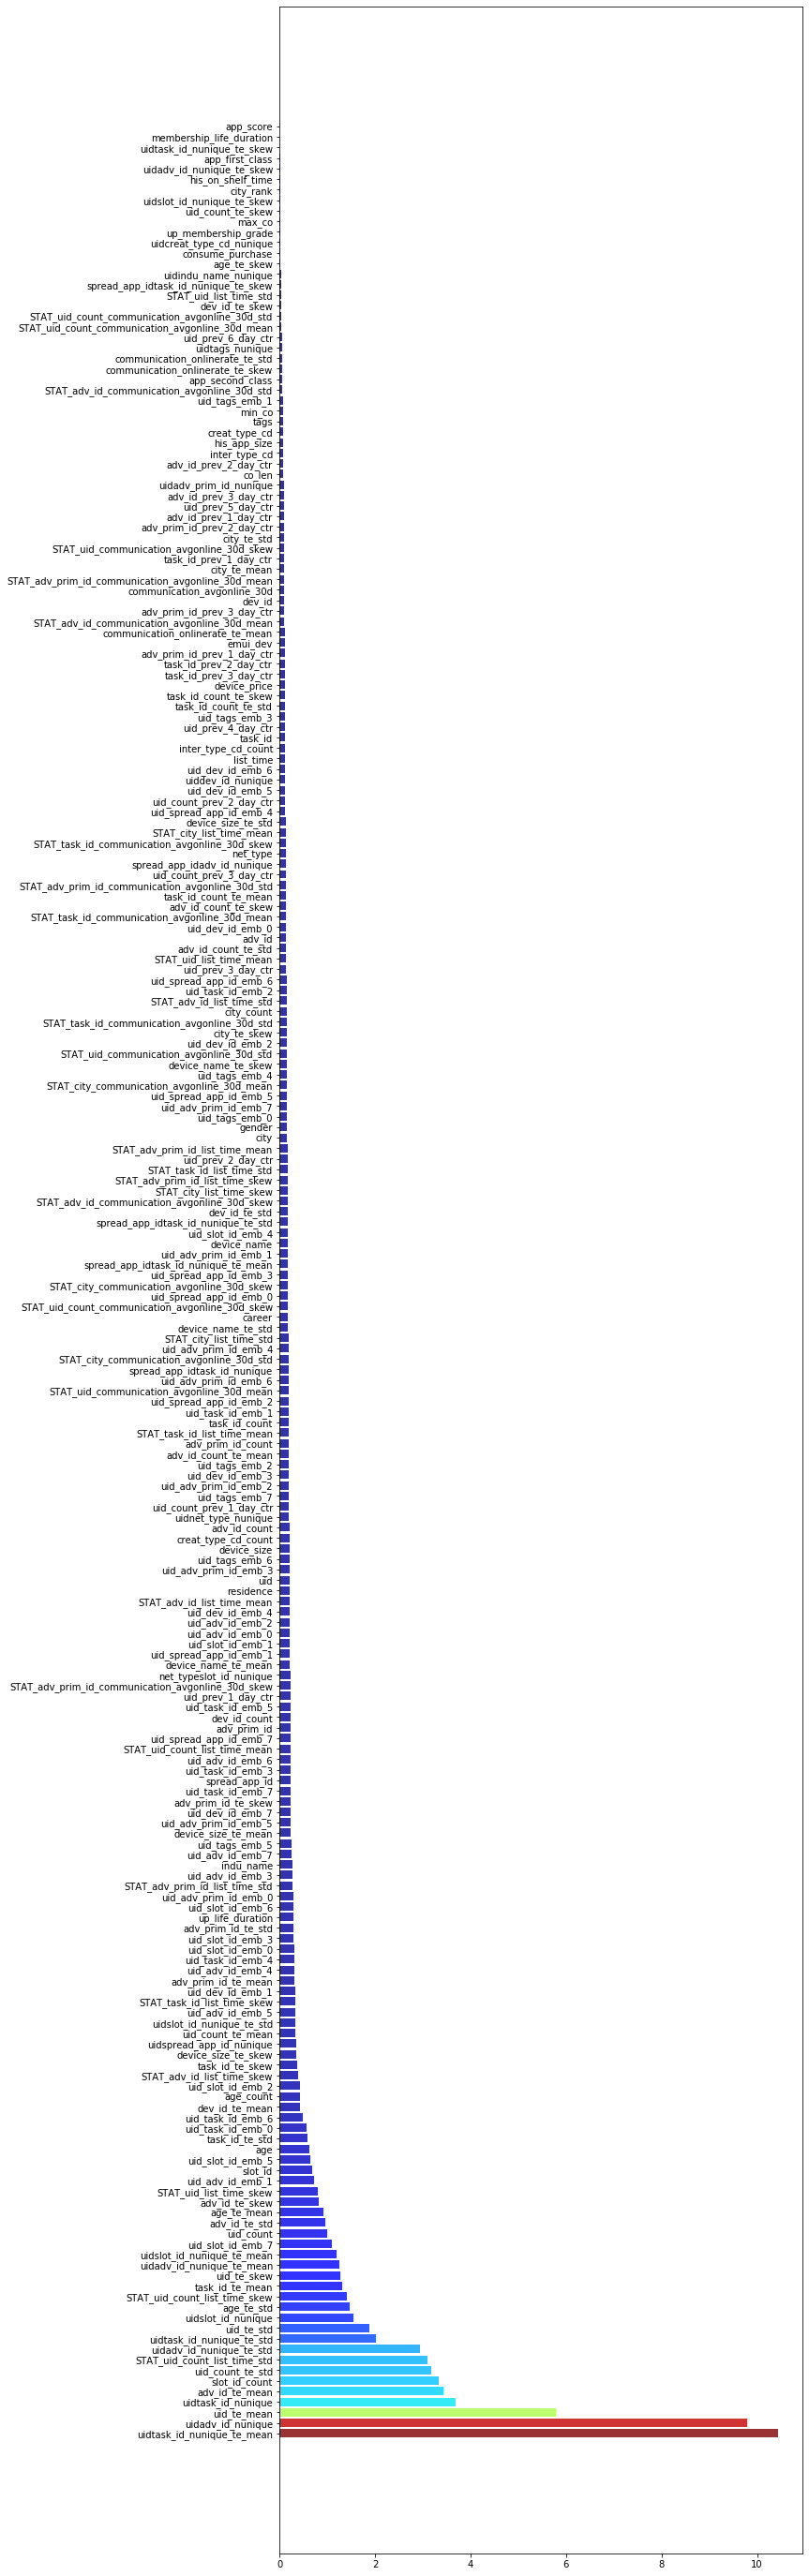

In [52]:
#查看模型的特征重要性
import matplotlib.pyplot as plt 
from matplotlib import cm
score = pd.DataFrame()
score['fea_name'] = clf.feature_names_
score['fea']=clf.feature_importances_
score = score.sort_values(['fea'], ascending=False)
temp = pd.DataFrame()
temp = score[:320]
color = cm.jet(temp['fea']/temp['fea'].max())
plt.figure(figsize=(10, 50))
plt.barh(temp['fea_name'],temp['fea'],height =0.8,color=color,alpha=0.8)
plt.show()

In [90]:
train_df[['app_first_class','app_score','app_second_class','career','city_rank','communication_avgonline_30d']].head(10)

,app_first_class,app_score,app_second_class,career,city_rank,communication_avgonline_30d
0,3,0,21,2,3,12
1,3,0,15,10,5,12
2,3,0,26,9,5,9
3,3,0,15,7,3,12
4,3,0,17,9,5,12
5,3,0,21,5,5,13
6,4,0,22,9,5,10
7,3,0,12,9,3,12
8,3,0,15,9,5,12
9,3,0,17,9,2,11


## 分特征打印importances

In [53]:
show_list = []
for s in train_df.columns:
    if '_nunique' in s:
        show_list.append(s)
print(show_list)

['uidslot_id_nunique', 'uidnet_type_nunique', 'uidtask_id_nunique', 'uidadv_id_nunique', 'uidadv_prim_id_nunique', 'uidcreat_type_cd_nunique', 'uiddev_id_nunique', 'uidtags_nunique', 'uidspread_app_id_nunique', 'uidindu_name_nunique', 'spread_app_idtask_id_nunique', 'spread_app_idadv_id_nunique', 'net_typeslot_id_nunique', 'uidtask_id_nunique_te_mean', 'uidtask_id_nunique_te_std', 'uidtask_id_nunique_te_skew', 'uidadv_id_nunique_te_mean', 'uidadv_id_nunique_te_std', 'uidadv_id_nunique_te_skew', 'uidslot_id_nunique_te_mean', 'uidslot_id_nunique_te_std', 'uidslot_id_nunique_te_skew', 'spread_app_idtask_id_nunique_te_mean', 'spread_app_idtask_id_nunique_te_std', 'spread_app_idtask_id_nunique_te_skew']


In [54]:
show=score[score['fea_name'].isin(show_list)]
show

,fea_name,fea
175,uidtask_id_nunique_te_mean,10.429547
49,uidadv_id_nunique,9.791890
48,uidtask_id_nunique,3.683325
179,uidadv_id_nunique_te_std,2.949524
176,uidtask_id_nunique_te_std,2.024661
46,uidslot_id_nunique,1.548504
178,uidadv_id_nunique_te_mean,1.257917
181,uidslot_id_nunique_te_mean,1.199367
54,uidspread_app_id_nunique,0.358396
182,uidslot_id_nunique_te_std,0.340174


In [55]:
show_list = []
for s in train_df.columns:
    if '_emb_' in s:
        show_list.append(s)
print(show_list)

['uid_task_id_emb_0', 'uid_task_id_emb_1', 'uid_task_id_emb_2', 'uid_task_id_emb_3', 'uid_task_id_emb_4', 'uid_task_id_emb_5', 'uid_task_id_emb_6', 'uid_task_id_emb_7', 'uid_adv_id_emb_0', 'uid_adv_id_emb_1', 'uid_adv_id_emb_2', 'uid_adv_id_emb_3', 'uid_adv_id_emb_4', 'uid_adv_id_emb_5', 'uid_adv_id_emb_6', 'uid_adv_id_emb_7', 'uid_slot_id_emb_0', 'uid_slot_id_emb_1', 'uid_slot_id_emb_2', 'uid_slot_id_emb_3', 'uid_slot_id_emb_4', 'uid_slot_id_emb_5', 'uid_slot_id_emb_6', 'uid_slot_id_emb_7', 'uid_tags_emb_0', 'uid_tags_emb_1', 'uid_tags_emb_2', 'uid_tags_emb_3', 'uid_tags_emb_4', 'uid_tags_emb_5', 'uid_tags_emb_6', 'uid_tags_emb_7', 'uid_dev_id_emb_0', 'uid_dev_id_emb_1', 'uid_dev_id_emb_2', 'uid_dev_id_emb_3', 'uid_dev_id_emb_4', 'uid_dev_id_emb_5', 'uid_dev_id_emb_6', 'uid_dev_id_emb_7', 'uid_adv_prim_id_emb_0', 'uid_adv_prim_id_emb_1', 'uid_adv_prim_id_emb_2', 'uid_adv_prim_id_emb_3', 'uid_adv_prim_id_emb_4', 'uid_adv_prim_id_emb_5', 'uid_adv_prim_id_emb_6', 'uid_adv_prim_id_emb_7',

In [56]:
show=score[score['fea_name'].isin(show_list)]
show

,fea_name,fea
82,uid_slot_id_emb_7,1.097909
68,uid_adv_id_emb_1,0.730256
80,uid_slot_id_emb_5,0.638533
59,uid_task_id_emb_0,0.560924
65,uid_task_id_emb_6,0.483284
77,uid_slot_id_emb_2,0.421989
72,uid_adv_id_emb_5,0.333520
92,uid_dev_id_emb_1,0.325214
71,uid_adv_id_emb_4,0.312320
63,uid_task_id_emb_4,0.307928


In [57]:
show_list = []
for s in train_df.columns:
    if 'STAT_' in s:
        show_list.append(s)
print(show_list)

['STAT_task_id_list_time_mean', 'STAT_task_id_list_time_std', 'STAT_task_id_list_time_skew', 'STAT_task_id_communication_avgonline_30d_mean', 'STAT_task_id_communication_avgonline_30d_std', 'STAT_task_id_communication_avgonline_30d_skew', 'STAT_adv_id_list_time_mean', 'STAT_adv_id_list_time_std', 'STAT_adv_id_list_time_skew', 'STAT_adv_id_communication_avgonline_30d_mean', 'STAT_adv_id_communication_avgonline_30d_std', 'STAT_adv_id_communication_avgonline_30d_skew', 'STAT_uid_list_time_mean', 'STAT_uid_list_time_std', 'STAT_uid_list_time_skew', 'STAT_uid_communication_avgonline_30d_mean', 'STAT_uid_communication_avgonline_30d_std', 'STAT_uid_communication_avgonline_30d_skew', 'STAT_uid_count_list_time_mean', 'STAT_uid_count_list_time_std', 'STAT_uid_count_list_time_skew', 'STAT_uid_count_communication_avgonline_30d_mean', 'STAT_uid_count_communication_avgonline_30d_std', 'STAT_uid_count_communication_avgonline_30d_skew', 'STAT_adv_prim_id_list_time_mean', 'STAT_adv_prim_id_list_time_st

In [58]:
show=score[score['fea_name'].isin(show_list)]
show

,fea_name,fea
134,STAT_uid_count_list_time_std,3.101886
135,STAT_uid_count_list_time_skew,1.404792
129,STAT_uid_list_time_skew,0.808624
123,STAT_adv_id_list_time_skew,0.384859
117,STAT_task_id_list_time_skew,0.332751
140,STAT_adv_prim_id_list_time_std,0.273974
133,STAT_uid_count_list_time_mean,0.229358
144,STAT_adv_prim_id_communication_avgonline_30d_skew,0.226418
121,STAT_adv_id_list_time_mean,0.212999
115,STAT_task_id_list_time_mean,0.195214


In [59]:
show_list = []
for s in train_df.columns:
    if '_count' in s:
        show_list.append(s)
print(show_list)

['slot_id_count', 'adv_id_count', 'adv_prim_id_count', 'creat_type_cd_count', 'inter_type_cd_count', 'age_count', 'city_count', 'uid_count', 'dev_id_count', 'task_id_count', 'STAT_uid_count_list_time_mean', 'STAT_uid_count_list_time_std', 'STAT_uid_count_list_time_skew', 'STAT_uid_count_communication_avgonline_30d_mean', 'STAT_uid_count_communication_avgonline_30d_std', 'STAT_uid_count_communication_avgonline_30d_skew', 'uid_count_prev_1_day_ctr', 'uid_count_prev_2_day_ctr', 'uid_count_prev_3_day_ctr', 'task_id_count_te_mean', 'task_id_count_te_std', 'task_id_count_te_skew', 'adv_id_count_te_mean', 'adv_id_count_te_std', 'adv_id_count_te_skew', 'uid_count_te_mean', 'uid_count_te_std', 'uid_count_te_skew']


In [60]:
show=score[score['fea_name'].isin(show_list)]
show

,fea_name,fea
36,slot_id_count,3.327560
197,uid_count_te_std,3.173199
134,STAT_uid_count_list_time_std,3.101886
135,STAT_uid_count_list_time_skew,1.404792
43,uid_count,0.997624
41,age_count,0.422367
196,uid_count_te_mean,0.341119
133,STAT_uid_count_list_time_mean,0.229358
44,dev_id_count,0.227320
39,creat_type_cd_count,0.205255


In [61]:
show_list = []
for s in train_df.columns:
    if '_te_' in s:
        show_list.append(s)
print(show_list)

['task_id_count_te_mean', 'task_id_count_te_std', 'task_id_count_te_skew', 'adv_id_count_te_mean', 'adv_id_count_te_std', 'adv_id_count_te_skew', 'uidtask_id_nunique_te_mean', 'uidtask_id_nunique_te_std', 'uidtask_id_nunique_te_skew', 'uidadv_id_nunique_te_mean', 'uidadv_id_nunique_te_std', 'uidadv_id_nunique_te_skew', 'uidslot_id_nunique_te_mean', 'uidslot_id_nunique_te_std', 'uidslot_id_nunique_te_skew', 'spread_app_idtask_id_nunique_te_mean', 'spread_app_idtask_id_nunique_te_std', 'spread_app_idtask_id_nunique_te_skew', 'uid_te_mean', 'uid_te_std', 'uid_te_skew', 'task_id_te_mean', 'task_id_te_std', 'task_id_te_skew', 'adv_id_te_mean', 'adv_id_te_std', 'adv_id_te_skew', 'uid_count_te_mean', 'uid_count_te_std', 'uid_count_te_skew', 'adv_prim_id_te_mean', 'adv_prim_id_te_std', 'adv_prim_id_te_skew', 'dev_id_te_mean', 'dev_id_te_std', 'dev_id_te_skew', 'age_te_mean', 'age_te_std', 'age_te_skew', 'city_te_mean', 'city_te_std', 'city_te_skew', 'device_name_te_mean', 'device_name_te_std',

In [62]:
show=score[score['fea_name'].isin(show_list)]
show

,fea_name,fea
175,uidtask_id_nunique_te_mean,10.429547
187,uid_te_mean,5.788953
193,adv_id_te_mean,3.435498
197,uid_count_te_std,3.173199
179,uidadv_id_nunique_te_std,2.949524
176,uidtask_id_nunique_te_std,2.024661
188,uid_te_std,1.875667
206,age_te_std,1.467953
190,task_id_te_mean,1.314376
189,uid_te_skew,1.266886
